In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# Changing the current working directory
os.chdir('./mt_experiments')

In [3]:
import os
import torch

import warnings
from pathlib import Path
from wrappers.interactive import *
from wrappers.utils import visualize_alti
from wrappers.multilingual_transformer_wrapper import FairseqMultilingualTransformerHub

import alignment.align as align

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

2023-06-19 01:52:22 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


## Load model

Choose model size (small/big), data mode (generate/interactive), generation mode (teacher forcing/free decoding), and dataset.

In [4]:
model_size = 'small' # small (412M) /big (1.2B)
data_sample = 'interactive' # generate/interactive
teacher_forcing = True # teacher forcing/free decoding
dataset = 'gold'

In [5]:
# Paths
# Checkpoint path
ckpt_dir = Path(os.environ['M2M_CKPT_DIR'])
europarl_dir = Path("./data/de-en")

# Path to binarized data
if data_sample == 'generate':
    m2m_data_dir = Path(os.environ['M2M_DATA_DIR'])
    data_name_or_path=(f'{m2m_data_dir}/data_bin')
else:
    # use "." to avoid loading
    data_name_or_path='.'

# Checkpoint names
if model_size=='big':
    checkpoint_file = '1.2B_last_checkpoint.pt'
else:
    checkpoint_file = '418M_last_checkpoint.pt'

lang_flores_dict = {'en': 'eng', 'es': 'spa', 'zu': 'zul',
                    'de': 'deu', 'yo': 'yor', 'ms': 'msa',
                    'fr': 'fra', 'xh': 'xho'}
source_lang = 'de'
target_lang = 'en'

In [6]:
hub = FairseqMultilingualTransformerHub.from_pretrained(
    ckpt_dir,
    checkpoint_file=checkpoint_file,
    data_name_or_path=data_name_or_path,
    source_lang= source_lang,
    target_lang= target_lang,
    lang_pairs =f'{source_lang}-{target_lang}',
    fixed_dictionary=f'{ckpt_dir}/model_dict.128k.txt')

2023-06-19 01:52:51 | WARNING | fairseq.data.multilingual.multilingual_data_manager | External language dictionary is not provided; use lang-pairs to infer the set of supported languages. The language ordering is not stable which might cause misalignment in pretraining and finetuning.


## Get example for analysis

From provided test data (preprocessed folder)

In [7]:
if data_sample=='generate':
    # index in dataset
    i = 3

    sample = hub.get_sample('test', i)

    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    source_sentence = sample['src_tok']
    target_sentence = sample['tgt_tok']
    src_sent = sample['src_sent']
    tgt_sent = sample['tgt_sent']
    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")

### Get sample as interactive from tokenized file

In [8]:
if data_sample=='interactive':

    if dataset == 'iwslt':
        test_set_dir = iwslt14_dir
    if dataset == 'gold':
        test_set_dir = europarl_dir# / "processed_data/"
    elif dataset == 'flores':
        test_set_dir = flores_dir
    if dataset == 'flores':
        src = lang_flores_dict[source_lang]
        tgt = lang_flores_dict[target_lang]
    else:
        src = "de"
        tgt = "en"

    tokenizer = "spm"

    # index in dataset
    i = 1
    sample = hub.get_interactive_sample(i, test_set_dir,
                                        src, tgt, tokenizer)

    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    source_sentence = sample['src_tok']
    target_sentence = sample['tgt_tok']

    print(sample['src_word_sent'])
    print(sample['tgt_word_sent'])

    print(sample['src_tok'])
    print(sample['tgt_tok'])


das stimmt nicht !

but this is not what happens .

['__de__', '▁das', '▁stim', 'mt', '▁nicht', '▁!', '</s>']
['</s>', '__en__', '▁but', '▁this', '▁is', '▁not', '▁what', '▁happens', '▁.']


### Teacher Forcing

In [9]:
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)
    print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    predicted_sentence = hub.decode(pred_tensor, hub.task.target_dictionary)
    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")



GREEDY DECODING

Predicted sentence: 	 __mg__ That that is not true!!</s>


### Greedy decoding/Beam search

For greedy decoding, set beam=1

In [10]:
if not teacher_forcing:
    tgt_tensor_free = []
    print("\n\nBEAM SEARCH\n")
    # We provide src_tensor[1:] since hub.generate internally
    # adds the language tag for generating translations
    for pred in hub.generate(src_tensor[1:], beam=4,verbose=True):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.target_dictionary, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.target_dictionary.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    target_sentence = hub.decode(tgt_tensor, hub.task.target_dictionary, as_string=False)

    # Forward-pass to get the 'prediction' (predicted_sentence) when the top-hypothesis is in the decoder input
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    predicted_sentence = hub.decode(pred_tensor, hub.task.target_dictionary)
    pred_sent = hub.decode(pred_tensor, hub.task.target_dictionary, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}") # result should match beam search when beam=1

## ALTI analysis

### ALTI of the encoder

To check the mixing of information inside the decoder. Visualization show with and without main diagonal

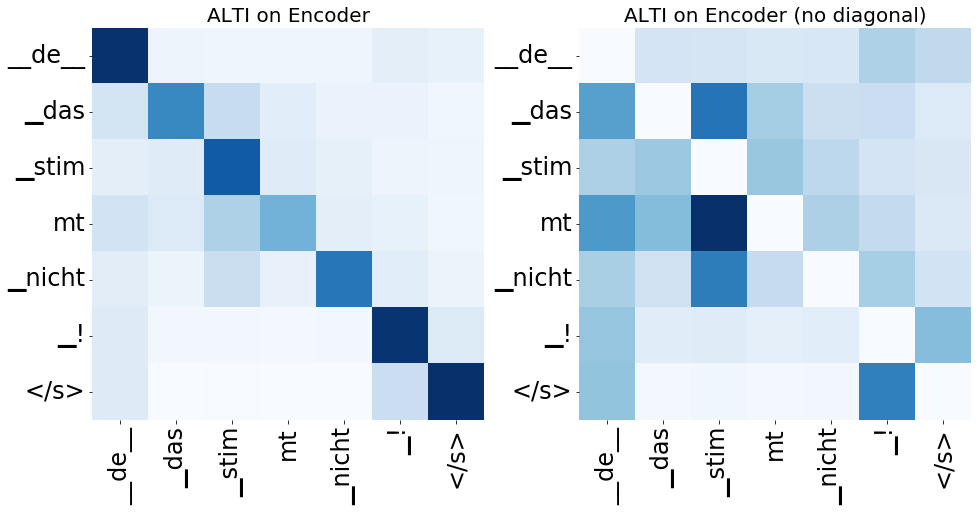

In [11]:
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1',
                                                        norm_mode='min_sum')['encoder.self_attn']
layer = -1                                                        
# Encoder self-attention relevances in last layer (full encoder ALTI)
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])
relevances_enc_self_attn_last = relevances_enc_self_attn[layer]
relevances_enc_self_attn_last_no_diag = relevances_enc_self_attn_last - torch.diag(relevances_enc_self_attn_last.diag())
df = pd.DataFrame(relevances_enc_self_attn_last.cpu().detach().numpy(),columns= source_sentence, index = source_sentence)
sns.set(font_scale=0.7)
sns.heatmap(df,cmap="Blues",ax=ax_left,square=True, cbar=False)
ax_left.set_title('ALTI on Encoder', fontsize=20)

df = pd.DataFrame(relevances_enc_self_attn_last_no_diag.cpu().detach().numpy(),columns= source_sentence, index = source_sentence)
sns.heatmap(df,cmap="Blues",ax=ax_right,square=True, cbar=False)
ax_right.set_title('ALTI on Encoder (no diagonal)', fontsize=20)
plt.gcf().subplots_adjust(bottom=0.2)

Attention weights (raw) in the cross attention at selected layer.
Corresponds to Figure 8-a of the paper

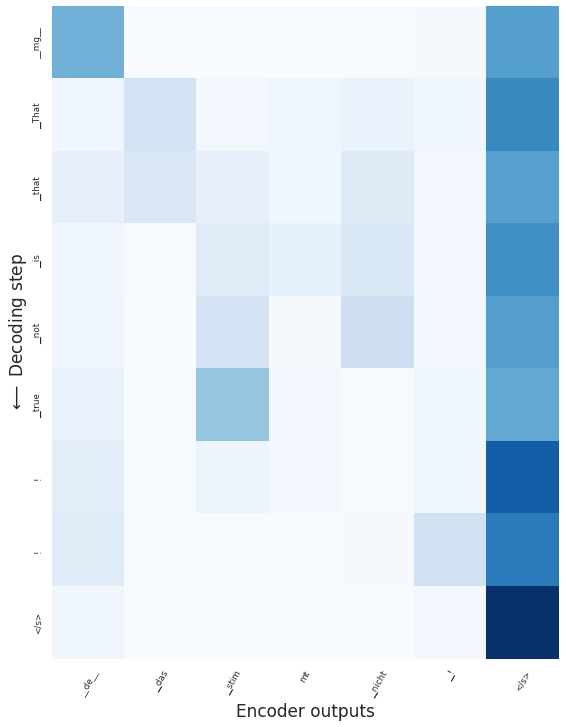

In [12]:
layer = 7

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'attn_w',
                                                                norm_mode='sum_one')['decoder.encoder_attn'])

cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(12,12))

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence ,index=predicted_sentence)
sns.set(font_scale=0.8)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel('Encoder outputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(rotation=60);

Cross-attention contributions $[\mathbf{C}_{\widetilde{\mathbf{y}}\gets\mathbf{e}};\mathbf{C}_{\widetilde{\mathbf{y}}\gets\widetilde{\bm{y}}^{s}_{t}}]$ of the encoder outputs $\mathbf{e}$ and residual $\widetilde{\bm y}_{t}^{s}$ to the decoder layer output.

Corresponds to Figure 8-b of the paper.

mean residual 0.8922364 std 0.058949217


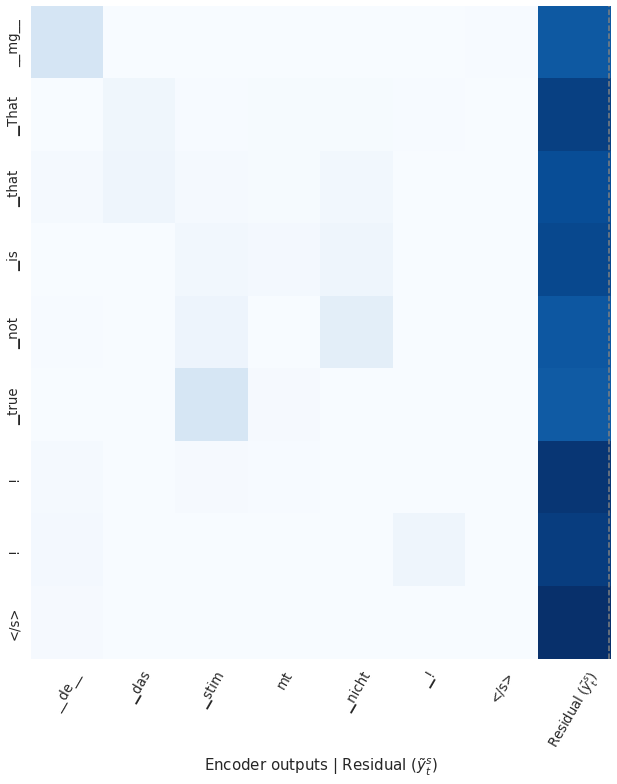

In [13]:
cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor,
                                        tgt_tensor, 'l1', norm_mode='min_sum',
                                        )['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()

layer = 7
plt.figure(figsize=(12,12))

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['Residual'],index=predicted_sentence)
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel(r'Encoder outputs | Residual $(\tilde{y}^{s}_{t})$', fontsize=15)
#s.set_ylabel('Prediction at step (t)', fontsize=14)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(ticks = plt.gca().get_xticks(), labels=source_sentence + [r'Residual $(\tilde{y}^{s}_{t})$'], rotation=60)

plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

print('mean residual',df['Residual'].mean(), 'std', df['Residual'].std())


### ALTI+

ALTI+ for the entire model. Last layer heatmap shows relevances of input tokens to the model prediction: $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{x}}$ | $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{\mathbf{y}_{<t}}}$

In [14]:
total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor,
                                            'l1', norm_mode='min_sum')['total']

contributions_rollout_layer_np (9, 16)


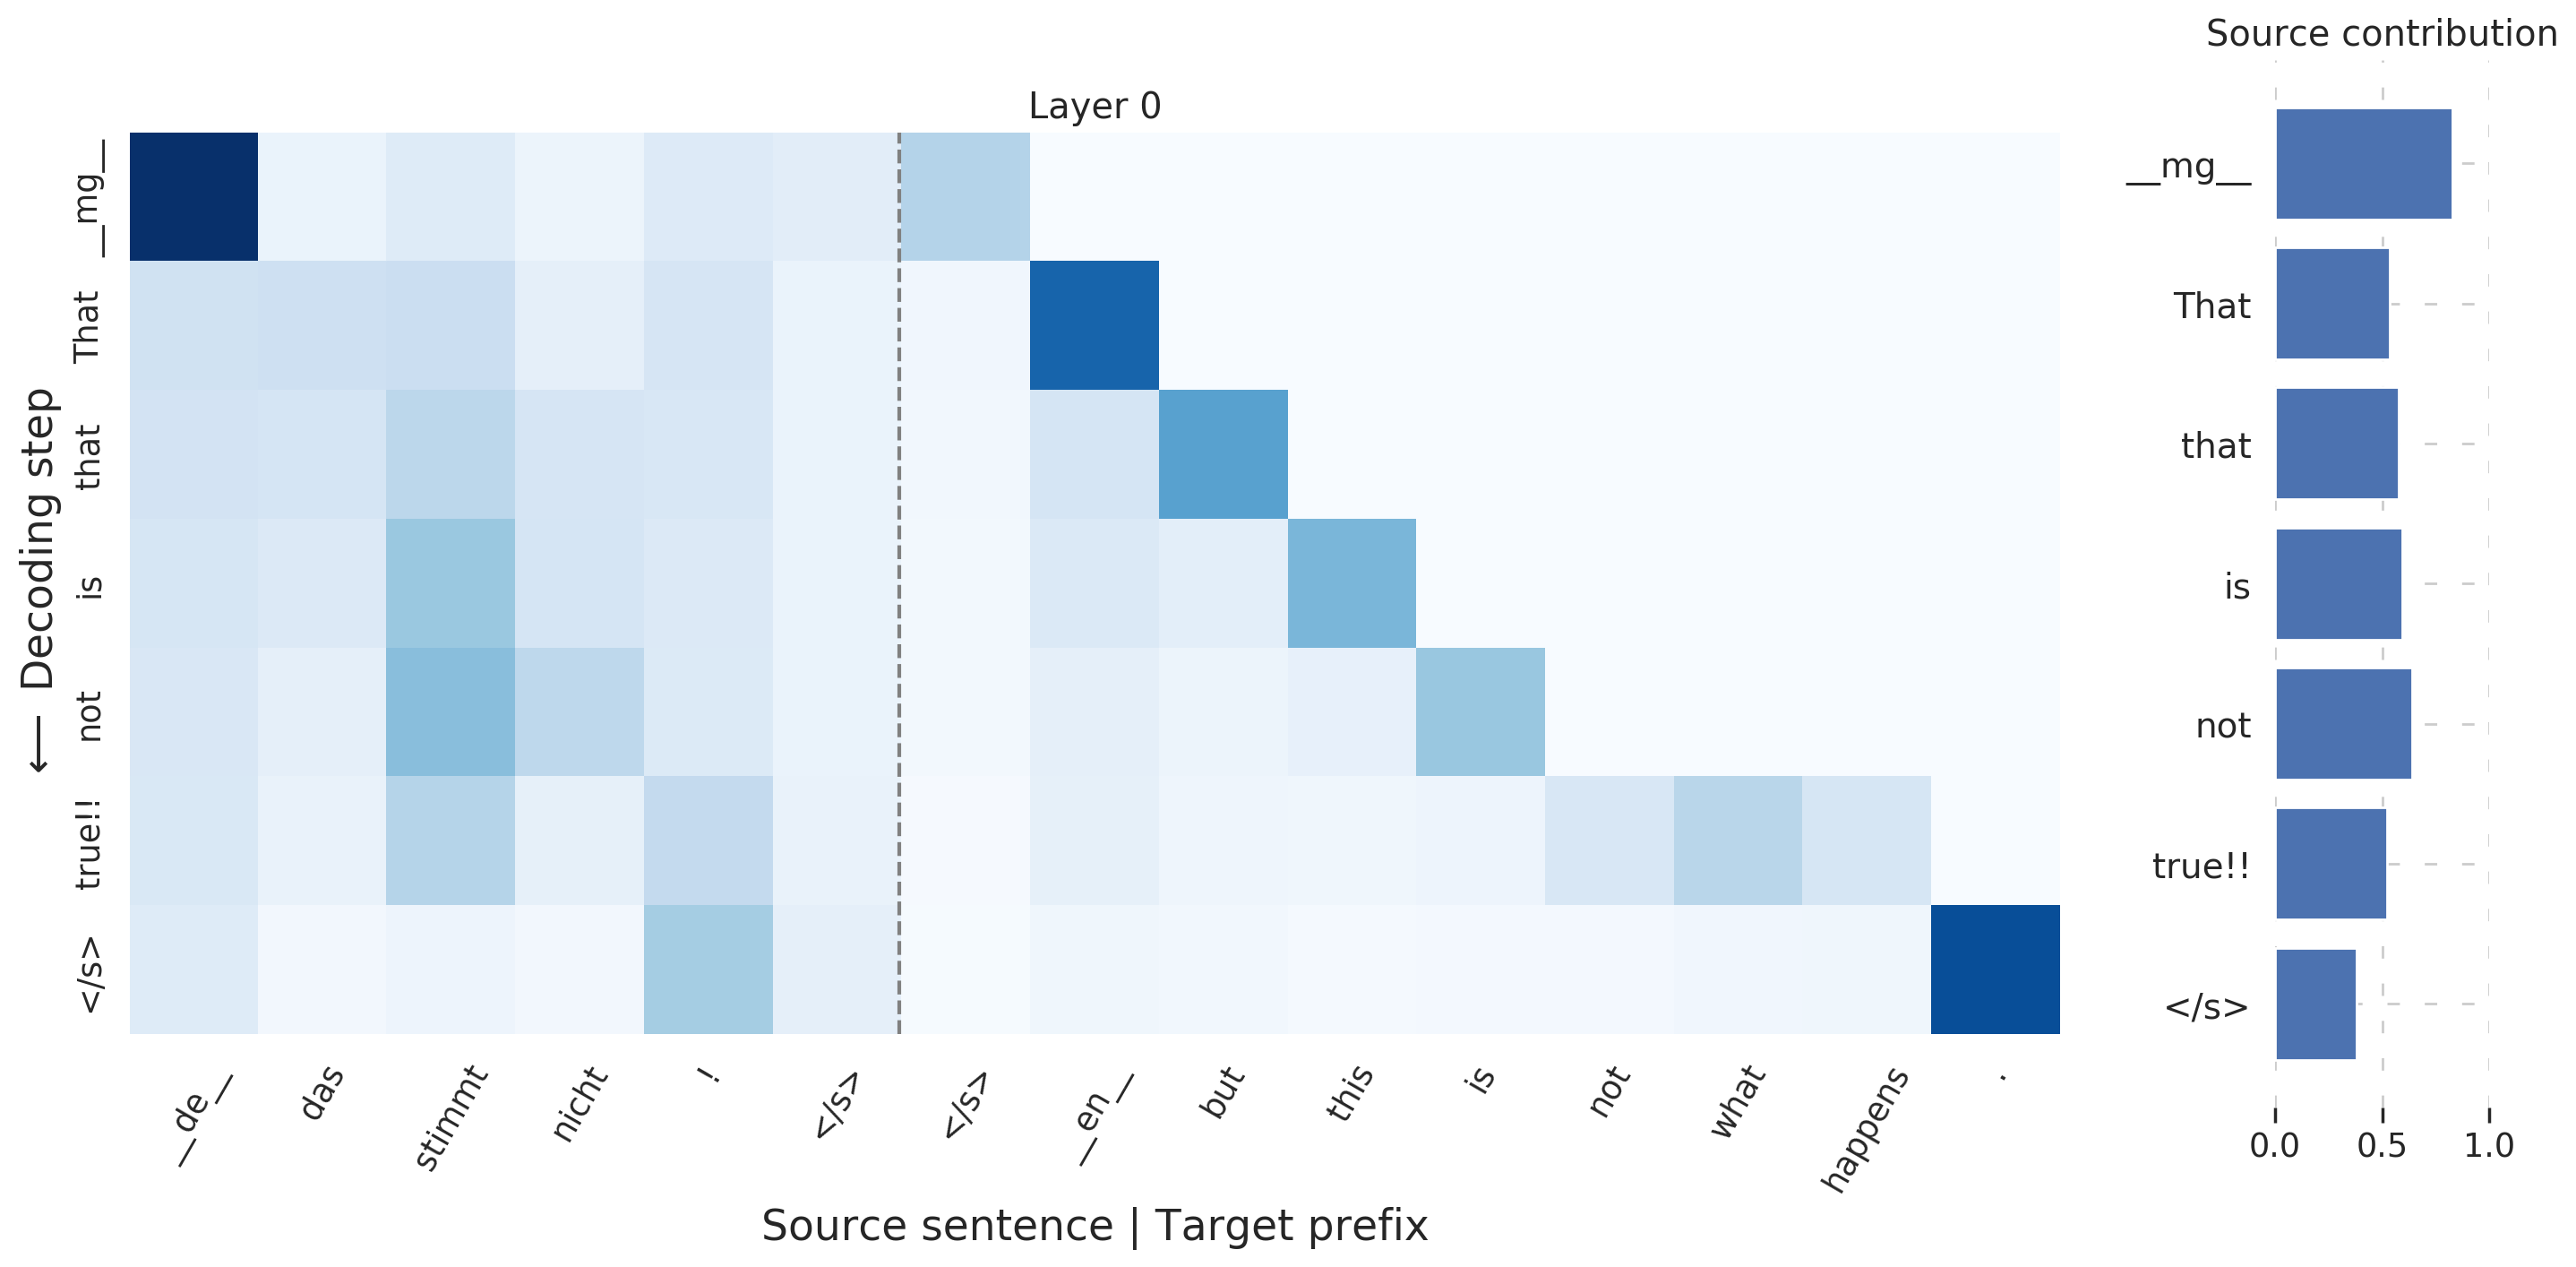

In [15]:
word_level = True
alignment = False # evaluating alignments, predictions (rows) are the reference (not showing real interpretations)

alti_result, source_sentence_, predicted_sentence_ = visualize_alti(total_alti, source_sentence,
                                                                    target_sentence, predicted_sentence,
                                                                    word_level, alignment, layer=-1)

## Word-word alignments (source-target) from contributions

In [16]:
alignments_src_tgt = alti_result[:,:len(source_sentence_)]
# Eliminate language tags
alignments_src_tgt = alignments_src_tgt[1:,1:]
# We don't consider alignment of EOS (target)
alignments_src_tgt = alignments_src_tgt[:-1]

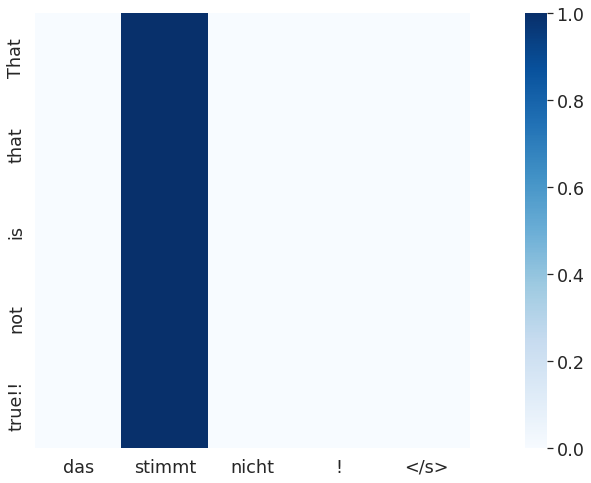

In [17]:
## Hard alignment
a_argmax = np.argmax(alignments_src_tgt, -1)
contributions_word_word_hard = np.zeros(alignments_src_tgt.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = source_sentence_[1:], index = predicted_sentence_[1:-1])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);